In [1]:
import quandl
import pandas as pd
import numpy as np
import talib
import csv
import warnings
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator

In [2]:
def plot_in_sample_hidden_states(hmm_model,df,series):
    """
    Plot the adjusted closing prices masked by 
    the in-sample hidden states as a mechanism
    to understand the market regimes.
    """
    # Predict the hidden states array
    hidden_states = hmm_model.predict(df)
    # Create the correctly formatted plot
    fig, axs = plt.subplots(
        hmm_model.n_components, 
        sharex=True, sharey=True,figsize=[20,20]
    )
    colours = cm.rainbow(
        np.linspace(0, 1, hmm_model.n_components)
    )
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = hidden_states == i
        ax.plot_date(
            df.index[mask], 
            series[mask], 
            ".", linestyle='none', 
            c=colour
        )
        ax.set_title("Hidden State #%s" % i)
        ax.xaxis.set_major_locator(YearLocator())
        ax.xaxis.set_minor_locator(MonthLocator())
        ax.grid(True)
    plt.show()

In [4]:
def merge_with_spy(df,spy):
    cut=df.loc['1993-01-29':]
    spy_out=spy[cut.index.strftime('%Y-%m-%d')]
    return cut,spy_out

In [15]:
def series_merge(a,b): #sometimes the series will be different length, this function makes each series only have the intersection of their date indices
    for i in a.index:
        if i not in b.index:
            a.drop(i,inplace=True)
    for i in b.index:
        if i not in b.index:
            b.drop(i,inplace=True)
    return(a,b)

In [17]:
import trading as td
from trading import generate_signals, eval_signals
from commodities import hard_tech,hard,hard_pct
from spy import spy,spy_pct

In [10]:
def hold_strat(row):
    return 1

In [18]:
trade=generate_signals(hard_pct,hold_strat)
hold_oil=eval_signals(hard_pct['pct_oil'],trade)

/Users/jamesbaker/miniconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


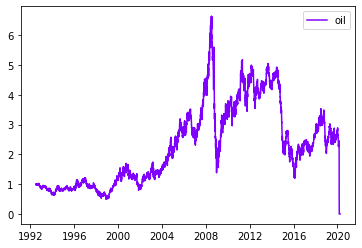

In [19]:
td.time_series_chart(oil=hold_oil)

In [55]:
train=hard_pct.iloc[:5000]
test=hard_pct.iloc[5000:6000]
hmm_model = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000).fit(train)

In [33]:
hmm_model

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=4, n_iter=1000, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [37]:
hmm_model.predict(test.iloc[0:1])

array([3])

In [41]:
def dumb_strat(row,hmm=hmm_model):
    ret=hmm.predict([row])
    return ret-1

In [48]:
tradeHMM=generate_signals(hard_pct['2015-01-01':],dumb_strat)

In [49]:
hmm_oil=eval_signals(hard_pct['pct_oil']['2015-01-01':],tradeHMM)

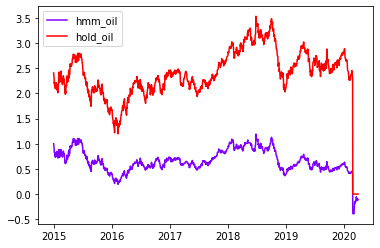

In [52]:
td.time_series_chart(hmm_oil=hmm_oil['2015-01-01':],hold_oil=hold_oil['2015-01-01':])

In [57]:
def simple_strat(row,hmm=hmm_model,mapping=[-1,0,1] ):
    ret=hmm.predict([row])[0]
    return mapping[ret]

In [58]:
tradeHMM2=generate_signals(hard_pct,simple_strat)

In [59]:
hmm_oil=eval_signals(hard_pct['pct_oil'],tradeHMM2)

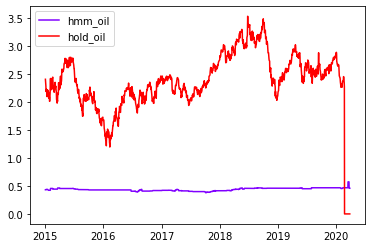

In [60]:
td.time_series_chart(hmm_oil=hmm_oil['2015-01-01':],hold_oil=hold_oil['2015-01-01':])

In [63]:
train=hard_tech.iloc[:5000]
test=hard_tech.iloc[5000:]
model_tech0=GaussianHMM(n_components=3, covariance_type="full", n_iter=1000).fit(train)

In [64]:
def tech_strat(row,hmm=model_tech0,mapping=[-1,0,1] ):
    ret=hmm.predict([row])[0]
    return mapping[ret]
tradeHMM_tech=generate_signals(test,tech_strat)

In [67]:
prices,sigs=series_merge(hard_pct['pct_oil'],tradeHMM_tech)
hmm_oil=eval_signals(prices,sigs)
#td.time_series_chart(hmm_oil=hmm_oil['2015-01-01':],hold_oil=hold_oil['2015-01-01':])

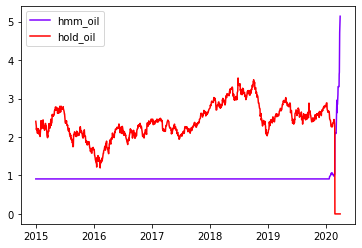

In [68]:
td.time_series_chart(hmm_oil=hmm_oil['2015-01-01':],hold_oil=hold_oil['2015-01-01':])

In [106]:
from functools import total_ordering

@total_ordering
class MarkovStrategy:
    def __init__(self,strat,returns,asset,model=None,params='technical'):
        self.strat=strat #strat function that returns -1,0,1
        self.params=params #the columns of the dataset taht feeds the input to the model
        self.returns=returns # the series actual returns that this portfolio yielded
        self.asset=asset #the name of the asset that this actually traded
        self.model=model #the actual markov model object
    
    def __lt__(self,other):
        return self.returns.iloc[len(self.returns)-1]<other.returns.iloc[len(other.returns)-1]
    
    def __eq__(self,other):
        return self.returns.iloc[len(self.returns)-1]==other.returns.iloc[len(other.returns)-1]
        
    def __str__(self):
        return str(self.returns.iloc[len(self.returns)-1])+' '+self.asset
    
    def __repr__(self):
        return self.__str__()
        

In [84]:
spy_pct.name='pct_spy'
assets=hard_pct.join(spy_pct).dropna()

In [121]:
def test_model_mapping(df=hard_tech, model=GaussianHMM,n_components=3,assets=assets,train_size=5000,begin_date='2015-01-01'):
    #makes a Markov model using the df, and finds the optimal mapping from states to trade signals
    train=df.iloc[:train_size]
    hmm=model(n_components=3, covariance_type="full", n_iter=1000).fit(train)
    models=[]
    for mapping in [[x,y,z] for x in [-1,0,1] for y in [-1,0,1] for z in [-1,0,1]]:
        def strat(row,hmm=hmm,mapping=mapping):
            ret=hmm.predict([row])[0]
            return mapping[ret]
        trade=generate_signals(df.loc[begin_date:],strat)
        for asset in assets.columns:
            prices,sigs=series_merge(assets[asset][begin_date:],trade)
            perf=eval_signals(prices,sigs)
            models.append(MarkovStrategy(strat,perf,asset))
    return sorted(models,reverse=True)
        

In [135]:
ranking=test_model_mapping(train_size=5000)

In [169]:
def benchmark_start(start_date,spy_pct=spy_pct):
    benchmark=1+spy_pct[start_date:]
    benchmark.iloc[0]=1
    for x in range(1,len(benchmark)):
        benchmark.iloc[x]*=benchmark.iloc[x-1]
    return benchmark
        
ben=benchmark('2015-01-01')


In [170]:
ben

2015-01-02    1.000000
2015-01-05    0.981940
2015-01-06    0.972691
2015-01-07    0.984812
2015-01-08    1.002288
                ...   
2020-03-30    1.273670
2020-03-31    1.254685
2020-04-01    1.198218
2020-04-02    1.225868
2020-04-03    1.208149
Name: pct_spy, Length: 1323, dtype: float64

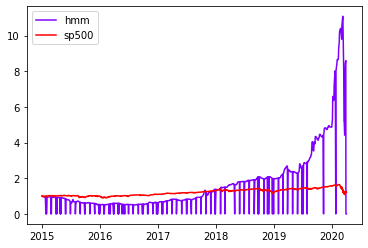

In [171]:
td.time_series_chart(hmm=ranking[0].returns['2015-01-01':],sp500=ben)

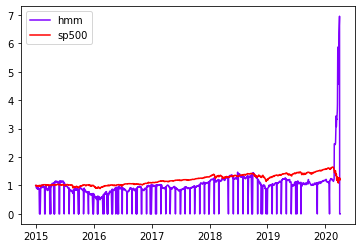

In [174]:
td.time_series_chart(hmm=ranking[3].returns['2015-01-01':],sp500=ben)

In [179]:
ranking[0].strat

<function __main__.test_model_mapping.<locals>.strat(row, hmm=GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=3, n_iter=1000, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False), mapping=[1, 1, -1])>

In [195]:
#ranking[0].returns['2015-01-01':].reset_index(ranking[0].returns['2015-01-01':].index.strftime("%Y-%m-%d"))
top_ranked=pd.Series(ranking[0].returns['2015-01-01':],index=ranking[0].returns['2015-01-01':].index.strftime("%Y-%m-%d"))

In [196]:
top_ranked

2015-01-02    1.000000
2015-01-05    1.000000
2015-01-06    1.000000
2015-01-07    0.979920
2015-01-08    0.971888
                ...   
2020-03-24    4.417671
2020-03-25    6.626506
2020-03-26    8.032129
2020-03-27    8.433735
2020-03-30    8.594378
Length: 1239, dtype: float64

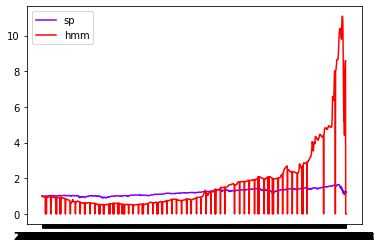

In [197]:
td.time_series_chart(sp=ben,hmm=top_ranked)

In [201]:
ben,top_ranked=series_merge(ben,top_ranked)

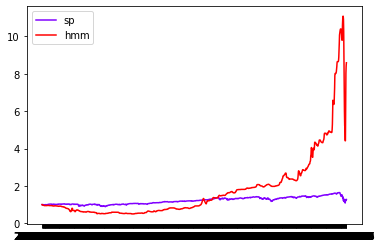

In [202]:
td.time_series_chart(sp=ben,hmm=top_ranked)

In [215]:
ben=benchmark('2015-01-01')
ben.index=pd.to_datetime(ben.index)
ben=pd.Series(ben,index=pd.to_datetime(ben.index))
ben

2015-01-02    1.000000
2015-01-05    0.981940
2015-01-06    0.972691
2015-01-07    0.984812
2015-01-08    1.002288
                ...   
2020-03-30    1.273670
2020-03-31    1.254685
2020-04-01    1.198218
2020-04-02    1.225868
2020-04-03    1.208149
Name: pct_spy, Length: 1323, dtype: float64

In [217]:
top_ranked=ranking[0].returns['2015-01-01':]
ben,top_ranked=series_merge(ben,top_ranked)

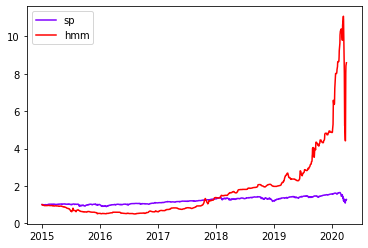

In [218]:
td.time_series_chart(sp=ben,hmm=top_ranked)

In [213]:
ben

Series([], Name: pct_spy, dtype: float64)

In [212]:
top_ranked

Date
2015-01-02    1.000000
2015-01-05    1.000000
2015-01-06    1.000000
2015-01-07    0.979920
2015-01-08    0.971888
                ...   
2020-03-24    4.417671
2020-03-25    6.626506
2020-03-26    8.032129
2020-03-27    8.433735
2020-03-30    8.594378
Length: 1239, dtype: float64

In [216]:
pd.to_datetime(ben.index)

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26',
               '2020-03-27', '2020-03-30', '2020-03-31', '2020-04-01',
               '2020-04-02', '2020-04-03'],
              dtype='datetime64[ns]', length=1323, freq=None)